In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *
from sklearn.model_selection import KFold,cross_val_score

import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
mail = pd.read_csv('spam.csv', encoding = 'latin-1')
mail.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Dataset :
- v1: The Label,Spam or Not(ham)
- v2: The raw text.
- Unnamed: 2	Unnamed: 3	Unnamed: 4 are unwanted columns. 

## EDA

In [3]:
mail.drop(columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis = 1, inplace = True)

In [4]:
mail.shape

(5572, 2)

In [5]:
mail.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
mail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## Visualization

<AxesSubplot:xlabel='v1', ylabel='count'>

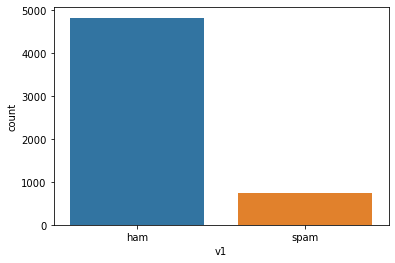

In [7]:
sns.countplot(mail.v1)

In [8]:
mail['v1'].replace('ham',0, inplace = True)
mail['v1'].replace('spam',1, inplace = True)

In [9]:
mail.v1.value_counts()

0    4825
1     747
Name: v1, dtype: int64

## Natural Language Processing (NLP) 

## Data Preprocessing

**- Converting to lower**

In [10]:
mail['v2'] = mail['v2'].str.lower()

**- Stop Words**

In [11]:
stop_words = stopwords.words('english')

**- Original Length**

In [12]:
original = mail['v2'].str.len()

**- Email Addresses**

In [13]:
mail['v2'] = mail['v2'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','email')

**- Website**

In [14]:
mail['v2'] = mail['v2'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','website')

**- Phone Number**

In [15]:
mail['v2'] = mail['v2'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

**- Currency**

In [16]:
mail['v2'] = mail['v2'].str.replace(r'£|\$', 'dollers')

**- Numbers**

In [17]:
mail['v2'] = mail['v2'].str.replace(r'\d+(\.\d+)?', 'number')

**- Dealing with Punctuation**

In [18]:
mail['v2'] = mail['v2'].apply(lambda x: ' '.join(term for term in x.split() 
                                                                                 if term not in string.punctuation))

**- Removing Stop word**

In [19]:
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
mail['v2'] = mail['v2'].apply(lambda x: ' '.join(term for term in x.split() 
                                                                                 if term not in stop_words))

**- Applying Lemmatization**

In [20]:
lem = WordNetLemmatizer()
mail['v2'] = mail['v2'].apply(lambda x: ' '.join(lem.lemmatize(t) 
                                                                                 for t in x.split()))

**- Cleaned Length**

In [21]:
clean = mail.v2.str.len()

In [22]:
print ('Origian Length :', original.sum())
print ('Clean Length :', clean.sum())

Origian Length : 446422
Clean Length : 336896


## WordCloud

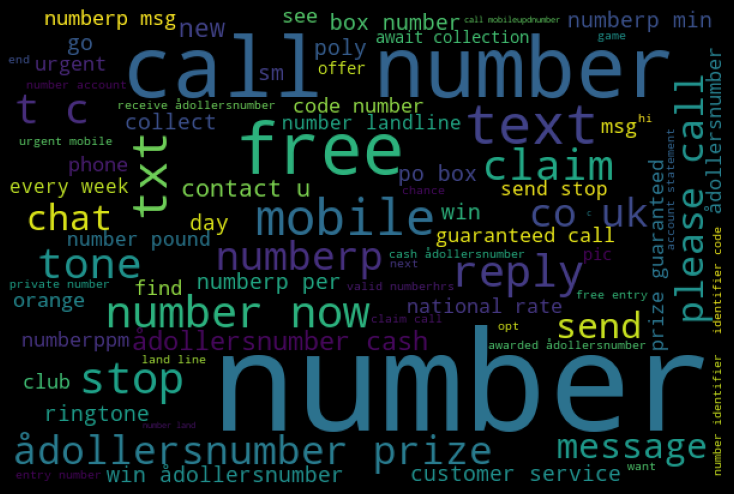

In [23]:
hams = mail['v2'][mail['v1']==1]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=80).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Final Dataset

In [24]:
mail

,v1,v2
0,0,"go jurong point, crazy.. available bugis n gre..."
1,0,ok lar... joking wif oni...
2,1,free entry number wkly comp win fa cup final t...
3,0,dun say early hor... c already say...
4,0,"nah think go usf, life around though"
...,...,...
5567,1,numbernd time tried number contact u. ådollers...
5568,0,ì_ b going esplanade fr home?
5569,0,"pity, mood that. so...any suggestions?"
5570,0,guy bitching acted like i'd interested buying ...


## Encoding

**TF-IDF Vectorization**

In [25]:
tf_vec = TfidfVectorizer(max_features = 10000, stop_words='english')
features = tf_vec.fit_transform(mail['v2'])
x = features

In [26]:
y = mail.v1

## Model Building

**- Train Test Split**

In [27]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25, random_state = 90)

**- Function for Training & Testing**

In [28]:
def score(clas, x_train, x_test, y_train, y_test, train = True):
    if train:
        y_pred = clas.predict(x_train)
        print('\n ----- Train Result ----- \n')
        print('Accuracy Score:', accuracy_score(y_train,y_pred))
        print('\n ----- Classification Report ----- \n', classification_report(y_train,y_pred))
        print('\n ----- Confusion matrix ----- \n', confusion_matrix(y_train,y_pred))
    
    elif train == False:
        pred = clas.predict(x_test)
        print('\n ----- Test Result ----- \n')
        print('Accuracy Score:', accuracy_score(y_test,pred))
        print('\n ----- Classification Report ----- \n', classification_report(y_test,pred))
        print('\n ----- Confusion matrix ----- \n', confusion_matrix(y_test,pred))
        print('\n ----- Roc Curve ----- \n')
        plot_roc_curve(clas, x_test, y_test) 

**- Model Instantiating**

In [29]:
ada = AdaBoostClassifier()
gbr = GradientBoostingClassifier()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
navie = GaussianNB()

**- AdaBoost Classifier.**


 ----- Train Result ----- 

Accuracy Score: 0.9868389566882029

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3613
           1       0.99      0.92      0.95       566

    accuracy                           0.99      4179
   macro avg       0.99      0.96      0.97      4179
weighted avg       0.99      0.99      0.99      4179


 ----- Confusion matrix ----- 
 [[3606    7]
 [  48  518]]

 ----- Test Result ----- 

Accuracy Score: 0.9791816223977028

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1212
           1       0.95      0.88      0.92       181

    accuracy                           0.98      1393
   macro avg       0.97      0.94      0.95      1393
weighted avg       0.98      0.98      0.98      1393


 ----- Confusion matrix ----- 
 [[1204    8]
 [  21  160]]

 ----- Roc Curve -----

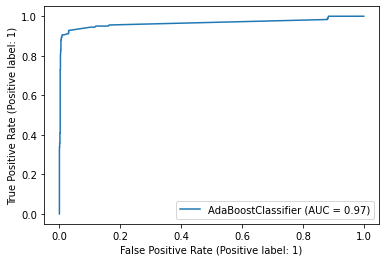

In [30]:
ada.fit(x_train,y_train)
score(ada, x_train,x_test,y_train,y_test,train = True)
score(ada, x_train,x_test,y_train,y_test,train = False)

**- GradientBoosting Classifier.**


 ----- Train Result ----- 

Accuracy Score: 0.9882747068676717

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3613
           1       1.00      0.92      0.95       566

    accuracy                           0.99      4179
   macro avg       0.99      0.96      0.97      4179
weighted avg       0.99      0.99      0.99      4179


 ----- Confusion matrix ----- 
 [[3612    1]
 [  48  518]]

 ----- Test Result ----- 

Accuracy Score: 0.9849246231155779

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1212
           1       0.99      0.89      0.94       181

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.97      1393
weighted avg       0.99      0.98      0.98      1393


 ----- Confusion matrix ----- 
 [[1211    1]
 [  20  161]]

 ----- Roc Curve -----

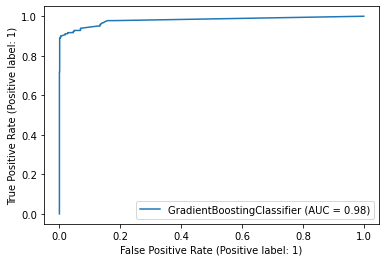

In [31]:
gbr.fit(x_train,y_train)
score(gbr, x_train,x_test,y_train,y_test,train = True)
score(gbr, x_train,x_test,y_train,y_test,train = False)

**- KNeighborsClassifier.**


 ----- Train Result ----- 

Accuracy Score: 0.9270160325436707

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      3613
           1       1.00      0.46      0.63       566

    accuracy                           0.93      4179
   macro avg       0.96      0.73      0.80      4179
weighted avg       0.93      0.93      0.92      4179


 ----- Confusion matrix ----- 
 [[3613    0]
 [ 305  261]]

 ----- Test Result ----- 

Accuracy Score: 0.914572864321608

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1212
           1       0.98      0.35      0.51       181

    accuracy                           0.91      1393
   macro avg       0.95      0.67      0.73      1393
weighted avg       0.92      0.91      0.90      1393


 ----- Confusion matrix ----- 
 [[1211    1]
 [ 118   63]]

 ----- Roc Curve ----- 

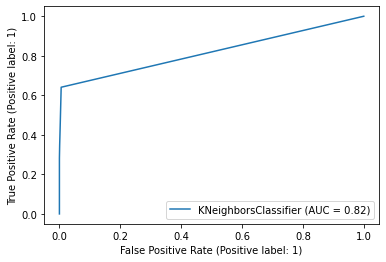

In [32]:
knn.fit(x_train,y_train)
score(knn, x_train,x_test,y_train,y_test,train = True)
score(knn, x_train,x_test,y_train,y_test,train = False)

**- RandomForest Classifier.**


 ----- Train Result ----- 

Accuracy Score: 0.9997607083034219

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3613
           1       1.00      1.00      1.00       566

    accuracy                           1.00      4179
   macro avg       1.00      1.00      1.00      4179
weighted avg       1.00      1.00      1.00      4179


 ----- Confusion matrix ----- 
 [[3612    1]
 [   0  566]]

 ----- Test Result ----- 

Accuracy Score: 0.9842067480258435

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1212
           1       1.00      0.88      0.94       181

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393


 ----- Confusion matrix ----- 
 [[1212    0]
 [  22  159]]

 ----- Roc Curve -----

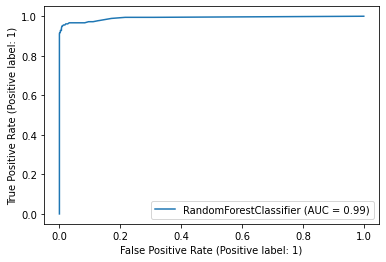

In [33]:
rf.fit(x_train,y_train)
score(rf, x_train,x_test,y_train,y_test,train = True)
score(rf, x_train,x_test,y_train,y_test,train = False)

**- Logistic Regression.**


 ----- Train Result ----- 

Accuracy Score: 0.9777458722182341

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3613
           1       0.97      0.86      0.91       566

    accuracy                           0.98      4179
   macro avg       0.98      0.93      0.95      4179
weighted avg       0.98      0.98      0.98      4179


 ----- Confusion matrix ----- 
 [[3600   13]
 [  80  486]]

 ----- Test Result ----- 

Accuracy Score: 0.9712849964106246

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1212
           1       0.99      0.79      0.88       181

    accuracy                           0.97      1393
   macro avg       0.98      0.89      0.93      1393
weighted avg       0.97      0.97      0.97      1393


 ----- Confusion matrix ----- 
 [[1210    2]
 [  38  143]]

 ----- Roc Curve -----

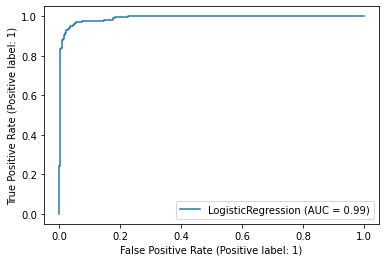

In [34]:
lr.fit(x_train,y_train)
score(lr, x_train,x_test,y_train,y_test,train = True)
score(lr, x_train,x_test,y_train,y_test,train = False)

**- Naive Bayes (GaussianNB).**

In [35]:
cv = CountVectorizer(max_features = 1500) 

In [36]:
X = cv.fit_transform(mail['v2']).toarray()
Y = mail.iloc[:, 1].values

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [38]:
def score_navie(clas, x_train, x_test, y_train, y_test, train = True):
    if train:
        y_pred = clas.predict(x_train)
        print('\n ----- Train Result ----- \n')
        print('Accuracy Score:', accuracy_score(y_train,y_pred))
    
    elif train == False:
        pred = clas.predict(x_test)
        print('\n ----- Test Result ----- \n')
        print('Accuracy Score:', accuracy_score(y_test,pred))

In [39]:
navie.fit(X_train,Y_train)
score_navie(navie, X_train,X_test,Y_train,Y_test,train = True)
score_navie(navie, X_train,X_test,Y_train,Y_test,train = False)


 ----- Train Result ----- 

Accuracy Score: 0.968413496051687

 ----- Test Result ----- 

Accuracy Score: 0.11198851399856424


        RandomForest Classifier is giving the best result as compared to other.

**Original vs Predicted**

In [40]:
a_rfc = np.array(y_test)
predicted_rfc = np.array(rf.predict(x_test))
df_rfc = pd.DataFrame({'Original':a_rfc,'Predicted':predicted_rfc})
df_rfc

,Original,Predicted
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1388,0,0
1389,0,0
1390,0,0
1391,0,0


## Cross Validation

In [41]:
k_f = KFold(n_splits = 3,shuffle = True)
k_f

KFold(n_splits=3, random_state=None, shuffle=True)

In [42]:
cross_val_score(rf,x,y,cv = 3).mean()

0.9818735884102261

    Model is not over-fitting, Model is working fine.

## Hyperparameter Tunning

In [43]:
param = {'n_estimators':range(0,100,10),
         'ccp_alpha':[0.0,0.2,0.4,0.5,0.7,0.8,1.0]
         }

In [44]:
grid = GridSearchCV(rf,param_grid = param)
grid.fit(x_train,y_train)
print('Best Params = ',grid.best_params_)

Best Params =  {'ccp_alpha': 0.0, 'n_estimators': 70}


In [45]:
rf_hyp = RandomForestClassifier(ccp_alpha = 0.0, n_estimators = 50)


 ----- Train Result ----- 

Accuracy Score: 0.9997607083034219

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3613
           1       1.00      1.00      1.00       566

    accuracy                           1.00      4179
   macro avg       1.00      1.00      1.00      4179
weighted avg       1.00      1.00      1.00      4179


 ----- Confusion matrix ----- 
 [[3612    1]
 [   0  566]]

 ----- Test Result ----- 

Accuracy Score: 0.9849246231155779

 ----- Classification Report ----- 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1212
           1       1.00      0.88      0.94       181

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.99      0.98      0.98      1393


 ----- Confusion matrix ----- 
 [[1212    0]
 [  21  160]]

 ----- Roc Curve -----

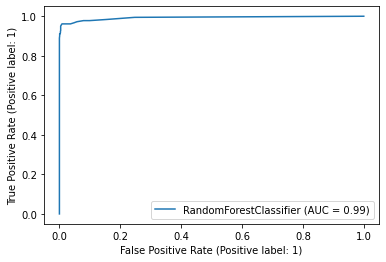

In [46]:
rf_hyp.fit(x_train,y_train)
score(rf_hyp, x_train,x_test,y_train,y_test,train = True)
score(rf_hyp, x_train,x_test,y_train,y_test,train = False)

    Post Tunning results & Pre Tunning results are almost same.

## Saving the model.

In [47]:
filename = 'Email_spam.pickle'
pickle.dump(rf, open(filename, 'wb'))